# Herzfehler Prognose
## Logistischeregression, Random Forest PDP
### Erklärbarkeit von Algorithmen
# ETL


In [68]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [69]:
df = pd.read_csv("../Heart Failure/data/heart.csv")

### Datenqualität

In [70]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [71]:
df.shape

(918, 12)

In [72]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [74]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [75]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Daten grobe Formatierung

In [76]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

### Spaltennamen umbenennen

In [77]:
df.columns = ["Alter", "Geschlecht", "Typ_Burstschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAgina", "Oldpeak", "ST_Steigung", "Herzversagen"]

### Cholesterin Werte: Null-Werte auf Durchschnitt nach der Zielvariable

In [78]:
# Berechnung der Durchschnittswerte
#durchschnitt_cholesterin_y0 = df.loc[(df['Herzversagen'] == 0) & (df['Cholesterin'] > 0), 'Cholesterin'].mean()
#durchschnitt_cholesterin_y1 = df.loc[(df['Herzversagen'] == 1) & (df['Cholesterin'] > 0), 'Cholesterin'].mean()

# Ersetze 0-Werte durch den entsprechenden Durchschnittswert
#df.loc[(df['Cholesterin'] == 0) & (df['Herzversagen'] == 0), 'Cholesterin'] = durchschnitt_cholesterin_y0
#df.loc[(df['Cholesterin'] == 0) & (df['Herzversagen'] == 1), 'Cholesterin'] = durchschnitt_cholesterin_y1
 

In [79]:
# Berechnung der Durchschnittswerte und Standardabweichungen
mittelwert_cholesterin_y0 = df.loc[(df['Herzversagen'] == 0) & (df['Cholesterin'] > 0), 'Cholesterin'].mean()
std_cholesterin_y0 = df.loc[(df['Herzversagen'] == 0) & (df['Cholesterin'] > 0), 'Cholesterin'].std()

mittelwert_cholesterin_y1 = df.loc[(df['Herzversagen'] == 1) & (df['Cholesterin'] > 0), 'Cholesterin'].mean()
std_cholesterin_y1 = df.loc[(df['Herzversagen'] == 1) & (df['Cholesterin'] > 0), 'Cholesterin'].std()

 # Ersetze 0-Werte durch zufällige Werte basierend auf der Normalverteilung des Durchschnitts und der Standardabweichung
df.loc[(df['Cholesterin'] == 0) & (df['Herzversagen'] == 0), 'Cholesterin'] = \
    np.random.normal(mittelwert_cholesterin_y0, std_cholesterin_y0, size=(df[(df['Cholesterin'] == 0) & (df['Herzversagen'] == 0)].shape[0]))
df.loc[(df['Cholesterin'] == 0) & (df['Herzversagen'] == 1), 'Cholesterin'] = \
    np.random.normal(mittelwert_cholesterin_y1, std_cholesterin_y1, size=(df[(df['Cholesterin'] == 0) & (df['Herzversagen'] == 1)].shape[0]))


# Daten Analyse

In [80]:
df.head()

,Alter,Geschlecht,Typ_Burstschmerz,Ruhender_Blutdruck,Cholesterin,Nüchterner_Blutzucker,Ruhe-EKG,Max_Herzrate,ExcerciseAgina,Oldpeak,ST_Steigung,Herzversagen
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0


### Verteilung Zielvariable Herzversagen

In [81]:
selected_columns = df.columns[:-1]

# Sortieren Sie den DataFrame, sodass die Werte mit Herzkrankheit = 1 zuerst kommen
df = df.sort_values(by='Herzversagen', ascending=False)

color_map = {0: 'red', 1: 'blue'}  # Rot für 0, Blau für 1

for attribut in selected_columns:
    fig = px.histogram(df, x=attribut, title=f"Histogramm von {attribut}", 
                       color='Herzversagen', opacity=0.8, barmode='overlay',
                       color_discrete_map=color_map)  # Definiere die Farben
    fig.show()


### Anzahl von Kranken und Gesunden

In [82]:
#Anzahl von Kranken und Gesunden
grouped_krankheiten = df.groupby(by="Herzversagen")
grouped_krankheiten["Herzversagen"].count()

Herzversagen
0    410
1    508
Name: Herzversagen, dtype: int64

### Korrelationsmatrix

<Axes: >

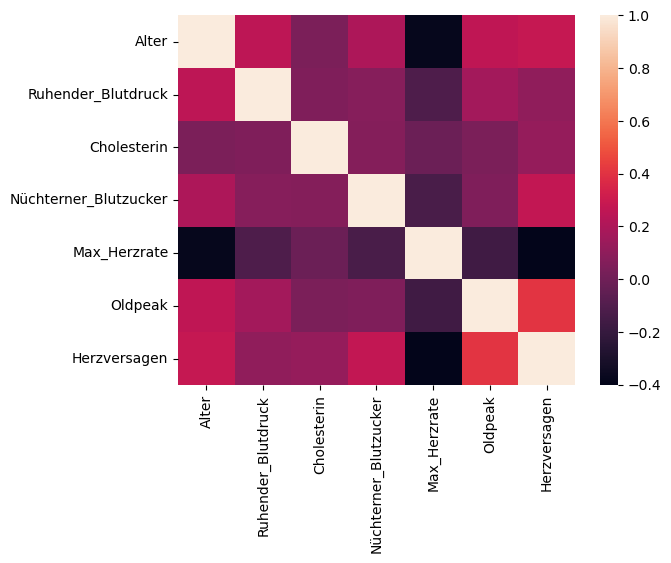

In [83]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False)

# Daten für Training vorbereiten

In [84]:
#Libs
from sklearn.model_selection import train_test_split

In [85]:
#Zielvariable definieren
X = df.drop("Herzversagen", axis=1)
y = df["Herzversagen"]

In [86]:
X.head()

,Alter,Geschlecht,Typ_Burstschmerz,Ruhender_Blutdruck,Cholesterin,Nüchterner_Blutzucker,Ruhe-EKG,Max_Herzrate,ExcerciseAgina,Oldpeak,ST_Steigung
325,42,M,ASY,105,275.969115,1,Normal,128,Y,-1.5,Down
412,56,M,ASY,125,305.828571,1,Normal,103,Y,1.0,Flat
405,35,M,ASY,120,222.576912,1,Normal,130,Y,1.2,Flat
406,57,M,ASY,140,126.485295,1,Normal,100,Y,0.0,Flat
407,62,M,ASY,115,312.123200,1,Normal,72,Y,-0.5,Flat


### Encoder
Für Logistische Regression und Random Forest

In [87]:
# Encoder Sci-Kit
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [88]:
kategorische_spalten = ["Geschlecht", "Typ_Burstschmerz", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAgina", "Oldpeak", "ST_Steigung"]
# Wandle kategorische Daten um
label_encoders = {}
for col in kategorische_spalten:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])
    label_encoders[col] = encoder  


### Normalisieren mit Scaler
Für Logistische Regression

In [89]:
# Normalisierung der Daten
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modeling Logistische Regression

In [90]:
#Bibliotheken
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [91]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

### Train, Test Data

In [92]:
# Aufteilung in Trainings- und Testdaten
X_train_scal, X_test_scal, y_train_scal, y_test_scal = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [93]:
# Ausgabe der Dimensionen der Trainings- und Testdaten
print("Trainingsdaten Größe:", X_train_scal.shape)
print("Testdaten Größe:", X_train_scal.shape)

Trainingsdaten Größe: (734, 11)
Testdaten Größe: (734, 11)


### Fit Learner LogisticRegression

In [94]:
# Erstellen und Trainieren des logistischen Regressionsmodells
model_lgr = LogisticRegression()
model_lgr.fit(X_train_scal, y_train_scal)

LogisticRegression()

### Prediction

In [95]:
# Vorhersagen auf Testdaten
y_pred_log = model_lgr.predict(X_test_scal)

### Confusion Matrix

In [96]:
from sklearn.metrics import confusion_matrix

In [97]:
# Erstellung der Konfusionsmatrix
conf_matrix_lg = confusion_matrix(y_test_scal, y_pred_log)

In [98]:
import seaborn as sns

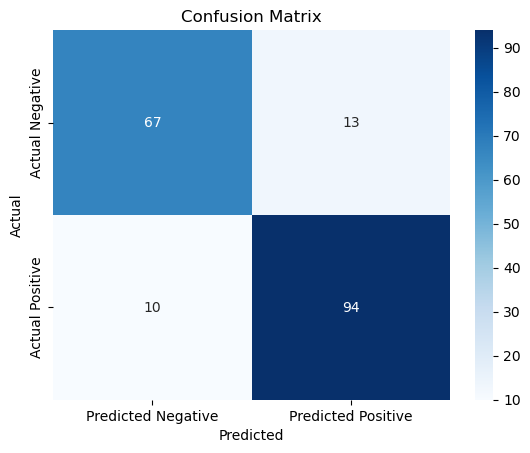

In [99]:
# Erstellung einer Heatmap zur visuellen Darstellung der Konfusionsmatrix
sns.heatmap(conf_matrix_lg, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### R2 - R Quadrat

In [100]:
from sklearn.metrics import r2_score

In [101]:
r2_score = r2_score(y_test_scal, y_pred_log)
print("R Quadrat Test: ", r2_score)

R Quadrat Test:  0.49134615384615377


### Area under the curve

In [102]:
from sklearn.metrics import roc_auc_score

In [103]:
print("Area under the curve:\n", roc_auc_score(y_test_scal, y_pred_log))

Area under the curve:
 0.8706730769230769


### Accuracy Score

In [104]:
# Bewertung des Modells
accuracy = accuracy_score(y_test_scal, y_pred_log)
print("Genauigkeit:", accuracy)

Genauigkeit: 0.875


### Klassifikationsbericht

In [105]:
class_report = classification_report(y_test_scal, y_pred_log)
print("Klassifikationsbericht:\n", class_report)

Klassifikationsbericht:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85        80
           1       0.88      0.90      0.89       104

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



# PDP LogReg Feature

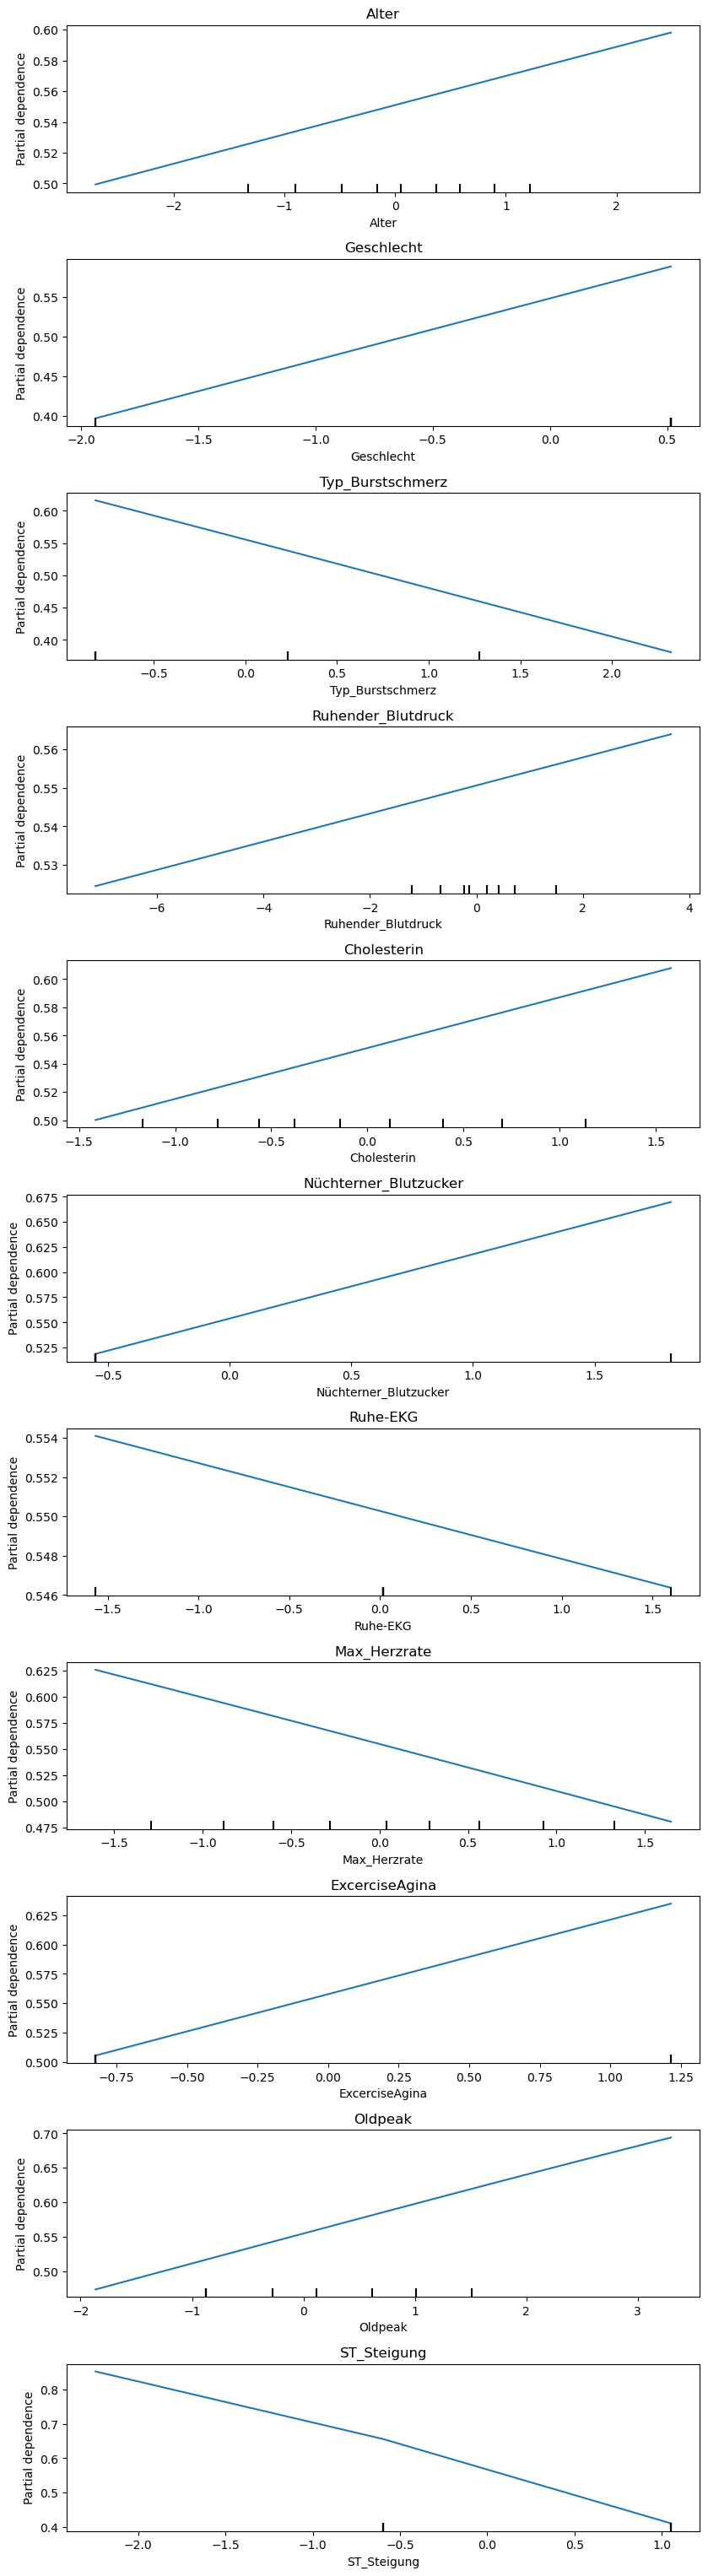

In [106]:
# Ihre Feature-Namen
feature_names = ['Alter', 'Geschlecht', 'Typ_Burstschmerz', 'Ruhender_Blutdruck',
       'Cholesterin', 'Nüchterner_Blutzucker', 'Ruhe-EKG', 'Max_Herzrate',
       'ExcerciseAgina', 'Oldpeak', 'ST_Steigung']

# Plot der Partial Dependence Plots
fig_width = 10  # Breite des Plots
fig_height_per_subplot = 3  # Höhe pro Subplot
fig, ax = plt.subplots(len(feature_names), 1, figsize=(fig_width, fig_height_per_subplot * len(feature_names)))

# Erzeugen der Partial Dependence Plots
for i, feature in enumerate(feature_names):
    disp = PartialDependenceDisplay.from_estimator(model_lgr, X_train_scal, features=[i],
                                                   feature_names=feature_names, ax=ax[i])
    ax[i].set_ylabel('')  # Entfernen der y-Achsen-Beschriftung
    ax[i].set_title(feature)  # Setzen des Feature-Namens als Titel

# Anpassung des Layouts
fig.subplots_adjust(top=0.95, bottom=0.05, left=0.2, right=0.95, hspace=0.4, wspace=0.2)

plt.show()

# Modeling Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
X.head()

,Alter,Geschlecht,Typ_Burstschmerz,Ruhender_Blutdruck,Cholesterin,Nüchterner_Blutzucker,Ruhe-EKG,Max_Herzrate,ExcerciseAgina,Oldpeak,ST_Steigung
325,42,1,0,105,275.969115,1,1,54,1,2,0
412,56,1,0,125,305.828571,1,1,29,1,20,1
405,35,1,0,120,222.576912,1,1,56,1,22,1
406,57,1,0,140,126.485295,1,1,27,1,10,1
407,62,1,0,115,312.123200,1,1,6,1,8,1


### Train, Test Data

In [109]:
# Aufteilung in Trainings- und Testdaten
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

### Learner

In [110]:
model_rf = RandomForestClassifier(max_depth=3, random_state=10)

### Fit Random Forest

In [111]:
model_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=3, random_state=10)

### Prediction

In [112]:
y_pred_rf = model_rf.predict(X_test_rf)

### Area under the curve

In [113]:
print("Area under the curve:\n", roc_auc_score(y_test_rf, y_pred_rf))

Area under the curve:
 0.8774038461538461


### Accuracy Score Random Forest

In [114]:
accuracy_score(y_test_rf,y_pred_rf)

0.8858695652173914

### Confusion Matrix

In [115]:
# Erstellung der Konfusionsmatrix
conf_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)

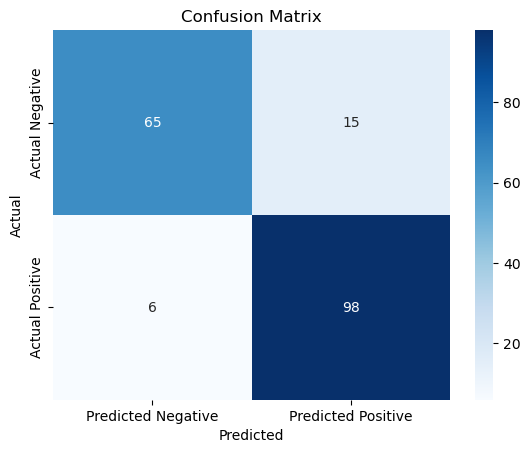

In [116]:
# Erstellung einer Heatmap zur visuellen Darstellung der Konfusionsmatrix
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Klassifikationsbericht

In [117]:
class_report = classification_report(y_test_rf, y_pred_rf)
print("Klassifikationsbericht:\n", class_report)

Klassifikationsbericht:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86        80
           1       0.87      0.94      0.90       104

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.88       184



# PDP Random Forest

In [118]:
from sklearn.inspection import partial_dependence


In [119]:
alter_index = feature_names.index("Alter")
pdp_results = partial_dependence(model_rf, X_train_rf, features=[alter_index])


In [120]:
pdp_alter_values = pdp_results['average'][0]  # Die durchschnittliche Abhängigkeit
pdp_alter_axis = pdp_results['values'][0]     # Die Werte für das Feature "Alter"

In [121]:

# Erstellen eines DataFrames zur Darstellung der Partial Dependence Daten
pdp_df = pd.DataFrame({
    'Alter': pdp_alter_axis,
    'Durchschnittliche Abhängigkeit': pdp_alter_values
})

# Anzeigen der Tabelle
print(pdp_df)

    Alter  Durchschnittliche Abhängigkeit
0      28                        0.531456
1      29                        0.531456
2      31                        0.531456
3      32                        0.531456
4      33                        0.531456
5      34                        0.531456
6      35                        0.531456
7      36                        0.531456
8      37                        0.531456
9      38                        0.533856
10     39                        0.533520
11     40                        0.534376
12     41                        0.534376
13     42                        0.534376
14     43                        0.534581
15     44                        0.534581
16     45                        0.535957
17     46                        0.541858
18     47                        0.541858
19     48                        0.541858
20     49                        0.543989
21     50                        0.543989
22     51                        0

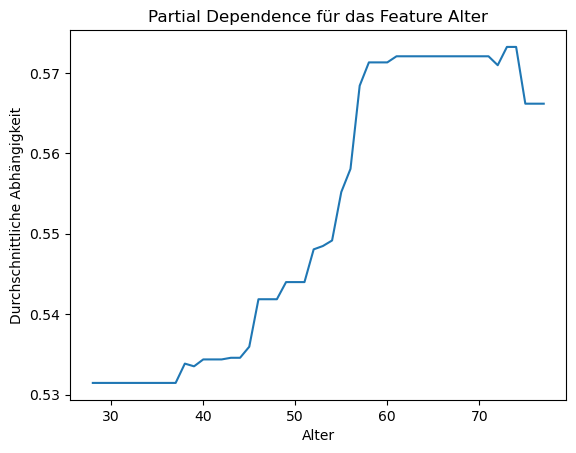

In [122]:
pdp_alter_values = pdp_results['average'][0]  # Die durchschnittliche Abhängigkeit
pdp_alter_axis = pdp_results['values'][0]     # Die Werte für das Feature "Alter"

# Plotting
plt.plot(pdp_alter_axis, pdp_alter_values)
plt.xlabel('Alter')
plt.ylabel('Durchschnittliche Abhängigkeit')
plt.title('Partial Dependence für das Feature Alter')
plt.show()


# PDP Random Forest

### PDP Alter

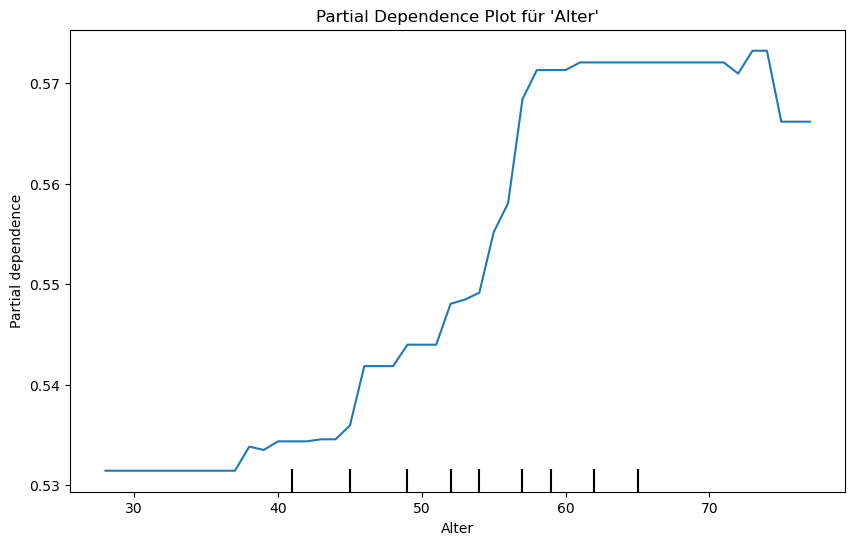

In [123]:

# Ihre Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes des Features "Alter" in der Liste der Feature-Namen
feature_index = feature_names.index("Alter")

# Erstellung des Partial Dependence Plots für das Feature "Alter"
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[feature_index],
    feature_names=feature_names, ax=ax)

ax.set_title("Partial Dependence Plot für 'Alter'")
plt.show()


### Conditional Cxpectation (ICE)
 shows the dependence between the target function and an input feature of interest. However, unlike a PDP, which shows the average effect of the input feature, an ICE plot visualizes the dependence of the prediction on a feature for each sample separately with one line per sample.

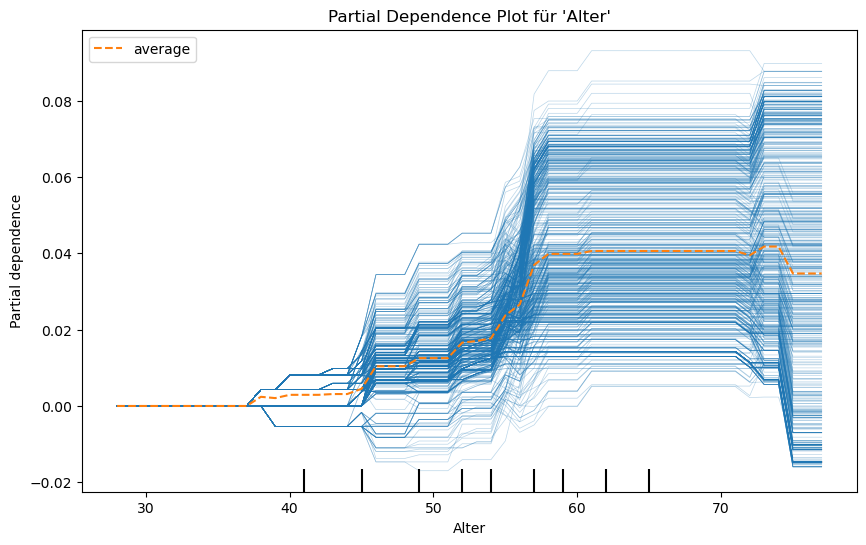

In [124]:

# Ihre Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes des Features "Alter" in der Liste der Feature-Namen
feature_index = feature_names.index("Alter")

# Erstellung des Partial Dependence Plots für das Feature "Alter"
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[feature_index],
    feature_names=feature_names, ax=ax,
    kind='both', centered=True)

ax.set_title("Partial Dependence Plot für 'Alter'")
plt.show()


### PDP 3D ST-Cholesterin, Geschlecht- Alter

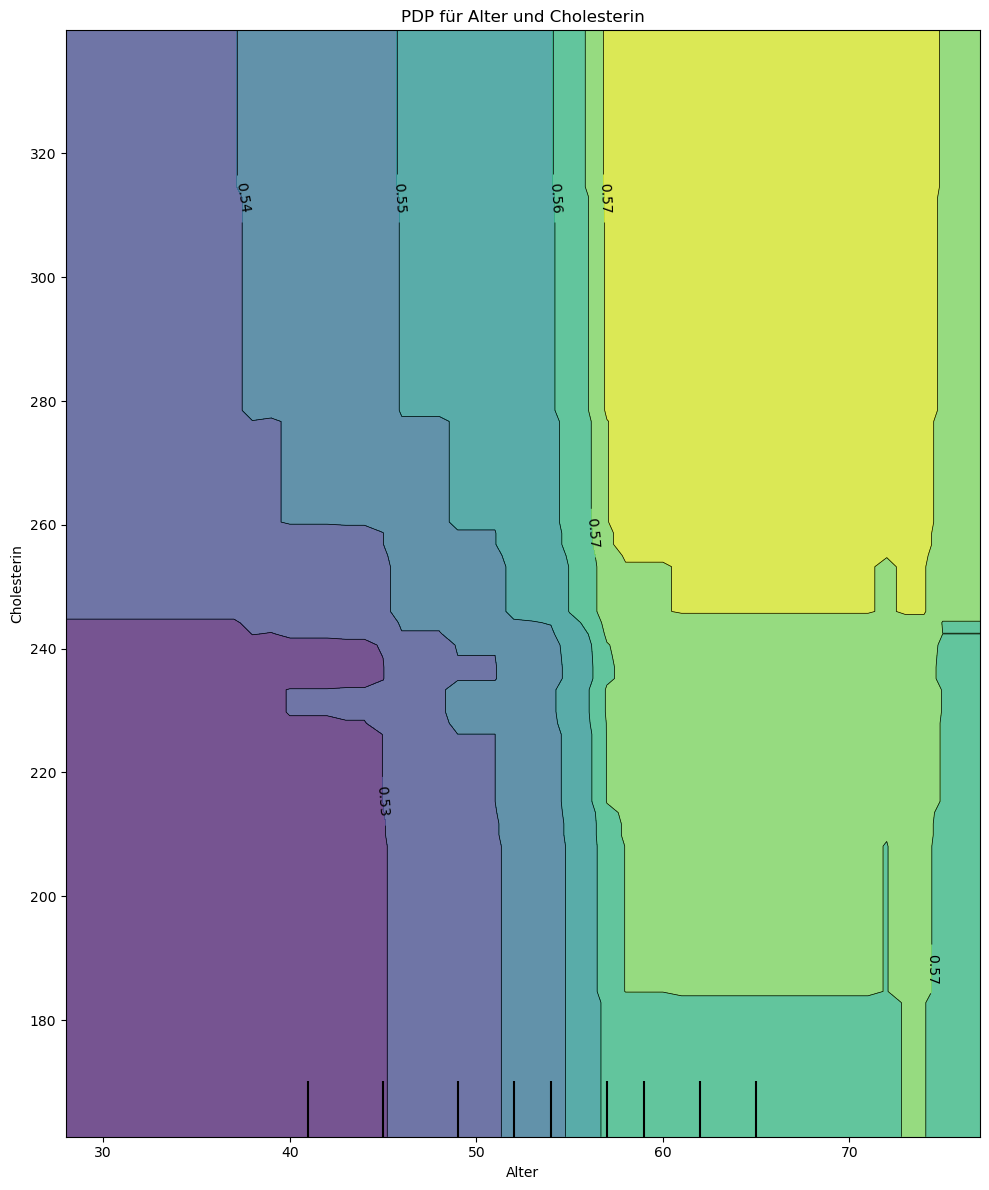

In [125]:
#  Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Brustschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAngina", "Oldpeak", "ST_Steigung"]

# Indizes der Features
alter_index = feature_names.index("Alter")
geschlecht_index = feature_names.index("Geschlecht")
cholesterin_index = feature_names.index("Cholesterin")
# Erstellung der Partial Dependence Plots
fig, axs = plt.subplots(figsize=(10, 12))

# PDP für Alter und Cholesterin
PartialDependenceDisplay.from_estimator(
    model_rf, X_train_rf, features=[(alter_index, cholesterin_index)],
    feature_names=feature_names, ax=axs)
axs.set_title("PDP für Alter und Cholesterin")


plt.tight_layout()
plt.show()


### Features PDP 2D

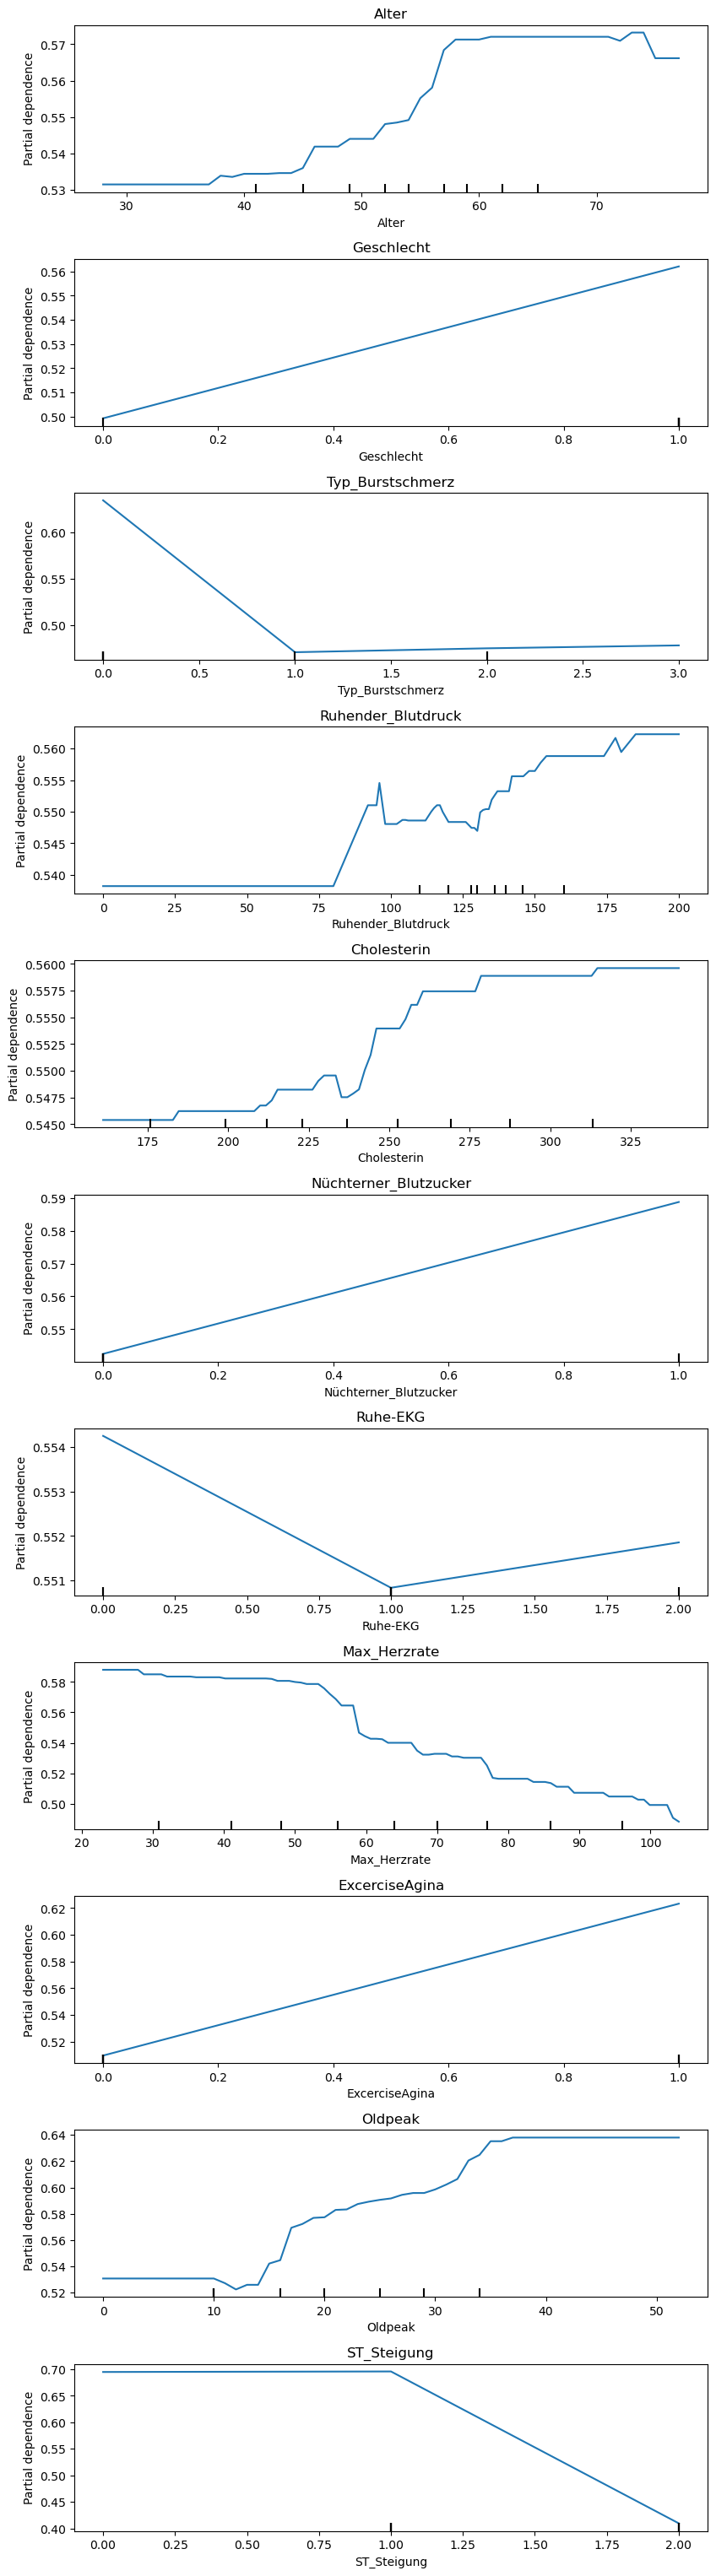

i: 10   feature:ST_Steigung


In [126]:
# Ihre Feature-Namen
feature_names = ["Alter", "Geschlecht", "Typ_Burstschmerz", "Ruhender_Blutdruck", "Cholesterin", "Nüchterner_Blutzucker", "Ruhe-EKG", "Max_Herzrate", "ExcerciseAgina", "Oldpeak", "ST_Steigung"]
# Plot der Partial Dependence Plots
fig_width = 10  # Breite des Plots
fig_height_per_subplot = 3  # Höhe pro Subplot
fig, ax = plt.subplots(len(feature_names), 1, figsize=(fig_width, fig_height_per_subplot * len(feature_names)))

# Erzeugen der Partial Dependence Plots
for i, feature in enumerate(feature_names):
    disp = PartialDependenceDisplay.from_estimator(model_rf, X_train_rf, features=[i],
                                                   feature_names=feature_names, ax=ax[i])
    ax[i].set_ylabel('')  # Entfernen der y-Achsen-Beschriftung
    ax[i].set_title(feature)  # Setzen des Feature-Namens als Titel

# Anpassung des Layouts
fig.subplots_adjust(top=0.95, bottom=0.05, left=0.2, right=0.95, hspace=0.4, wspace=0.2)

plt.show()
print(f'i: {i}   feature:{feature}')